In [1]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 113.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
#from matplotlib import pyplot as plt
import seaborn as sns

#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout

import autokeras as ak

In [5]:
train_df = pd.read_csv("./train.csv")
serving_df = pd.read_csv("./test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
def preprocess(df):
    df = df.copy()

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        return x.split(" ")[-1]

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292  
PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket 

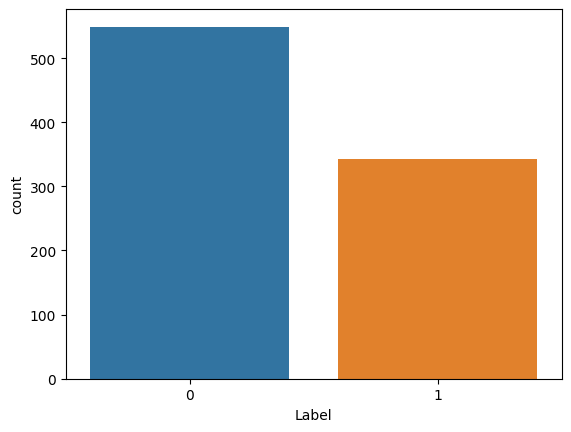

In [7]:
print(df.describe().T)  #Values need to be normalized before fitting.
print(df.isnull().sum())
#df = df.dropna()

#Rename Dataset to Label to make it easy to understand
df = df.rename(columns={'Survived':'Label'})
print(df.dtypes)

#Understand the data
sns.countplot(x="Label", data=df) #M - malignant   B - benign


df['Label'].value_counts()

#Define the dependent variable that needs to be predicted (labels)
y = df["Label"].values

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # M=1 and B=0

In [8]:
df.Sex[df.Sex == 'male'] = 1
df.Sex[df.Sex == 'female'] = 2
print(df)

     PassengerId  Label  Pclass  \
0              1      0       3   
1              2      1       1   
2              3      1       3   
3              4      1       1   
4              5      0       3   
..           ...    ...     ...   
886          887      0       2   
887          888      1       1   
888          889      0       3   
889          890      1       1   
890          891      0       3   

                                                Name Sex   Age  SibSp  Parch  \
0                              Braund Mr Owen Harris   1  22.0      1      0   
1    Cumings Mrs John Bradley Florence Briggs Thayer   2  38.0      1      0   
2                               Heikkinen Miss Laina   2  26.0      0      0   
3           Futrelle Mrs Jacques Heath Lily May Peel   2  35.0      1      0   
4                             Allen Mr William Henry   1  35.0      0      0   
..                                               ...  ..   ...    ...    ...   
886                

<ipython-input-8-22ca9ea9a02c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Sex[df.Sex == 'male'] = 1
<ipython-input-8-22ca9ea9a02c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Sex[df.Sex == 'female'] = 2


In [10]:
#Variáveis independentes
X = df.drop(labels = ["Label", "PassengerId","Name", "Ticket","Cabin","Embarked","Ticket_item"], axis=1)

print(X)

     Pclass Sex   Age  SibSp  Parch     Fare Ticket_number
0         3   1  22.0      1      0   7.2500         21171
1         1   2  38.0      1      0  71.2833         17599
2         3   2  26.0      0      0   7.9250       3101282
3         1   2  35.0      1      0  53.1000        113803
4         3   1  35.0      0      0   8.0500        373450
..      ...  ..   ...    ...    ...      ...           ...
886       2   1  27.0      0      0  13.0000        211536
887       1   2  19.0      0      0  30.0000        112053
888       3   2   NaN      1      2  23.4500          6607
889       1   1  26.0      0      0  30.0000        111369
890       3   1  32.0      0      0   7.7500        370376

[891 rows x 7 columns]


In [11]:

#Divide os dados entre train e test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.8709677457809448

Best val_accuracy So Far: 0.8709677457809448
Total elapsed time: 00h 00m 55s
Epoch 1/100
21/21 [==============================] - 1s 2ms/step - loss: 0.6509 - accuracy: 0.6617
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.5726 - accuracy: 0.7425
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.7740
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4930 - accuracy: 0.7844
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4722 - accuracy: 0.7964
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.8084
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4471 - accuracy: 0.8129
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.8129
Epoch 9/100
21/21 [==============================] - 0s 3ms/step 

7/7 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8027
Accuracy =  80.26905655860901 %
7/7 [==============================] - 0s 1ms/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 7)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                256       
                                                                 
 re_lu (ReLU)            

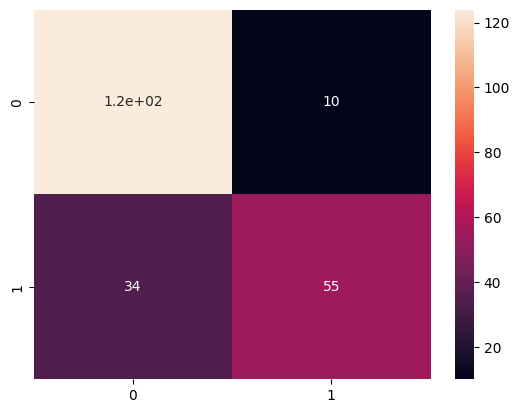

In [12]:

# define a busca
clf = ak.StructuredDataClassifier(max_trials = 10)
clf.fit(X_train, y_train, verbose=1, epochs=100)


#Avalia o classificador
_, acc = clf.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

# Prevendo os resultados do conjunto de teste
y_pred = clf.predict(X_test)
y_pred = (y_pred > 0.5)

# Matriz de confusão
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

# Modelo de melhor desempenho
model = clf.export_model()
print(model.summary())




In [13]:
preprocessed_serving_df.Sex[preprocessed_serving_df.Sex == 'male'] = 1
preprocessed_serving_df.Sex[preprocessed_serving_df.Sex == 'female'] = 2
print(preprocessed_serving_df)

     PassengerId  Pclass                                      Name Sex   Age  \
0            892       3                            Kelly Mr James   1  34.5   
1            893       3              Wilkes Mrs James Ellen Needs   2  47.0   
2            894       2                   Myles Mr Thomas Francis   1  62.0   
3            895       3                            Wirz Mr Albert   1  27.0   
4            896       3  Hirvonen Mrs Alexander Helga E Lindqvist   2  22.0   
..           ...     ...                                       ...  ..   ...   
413         1305       3                          Spector Mr Woolf   1   NaN   
414         1306       1                Oliva y Ocana Dona Fermina   2  39.0   
415         1307       3                Saether Mr Simon Sivertsen   1  38.5   
416         1308       3                         Ware Mr Frederick   1   NaN   
417         1309       3                    Peter Master Michael J   1   NaN   

     SibSp  Parch              Ticket  

<ipython-input-13-ad558f39853c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_serving_df.Sex[preprocessed_serving_df.Sex == 'male'] = 1
<ipython-input-13-ad558f39853c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_serving_df.Sex[preprocessed_serving_df.Sex == 'female'] = 2


In [14]:
X_test = preprocessed_serving_df.drop(labels = ["PassengerId","Name", "Ticket","Cabin","Embarked","Ticket_item"], axis=1)

print(X_test)

     Pclass Sex   Age  SibSp  Parch      Fare Ticket_number
0         3   1  34.5      0      0    7.8292        330911
1         3   2  47.0      1      0    7.0000        363272
2         2   1  62.0      0      0    9.6875        240276
3         3   1  27.0      0      0    8.6625        315154
4         3   2  22.0      1      1   12.2875       3101298
..      ...  ..   ...    ...    ...       ...           ...
413       3   1   NaN      0      0    8.0500          3236
414       1   2  39.0      0      0  108.9000         17758
415       3   1  38.5      0      0    7.2500       3101262
416       3   1   NaN      0      0    8.0500        359309
417       3   1   NaN      1      1   22.3583          2668

[418 rows x 7 columns]


In [15]:
# Prvento mais resultados do conjunto
y_pred = clf.predict(X_test)


14/14 [==============================] - 0s 1ms/step


In [16]:
print(y_pred)

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.

In [18]:
ss = pd.read_csv("./gender_submission.csv")

In [19]:
ss['Sobreviveu'] =y_pred
ss.to_csv('submission_1.csv', index=False)
print("Salvo com sucesso!")

Salvo com sucesso!
